# Speed of Dynamic Chebyshev

## Table of Contents
* [1) A Comparison with LSM](#first-bullet)
    - [1a) DC](#firsta-bullet)
    - [1b) LSM](#firstb-bullet)
* [2) Increasing Number of Nodal Points](#second-bullet)

## Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata
import os
import time
import warnings


# Global settings for LaTeX rendering
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['mathtext.fontset'] = 'cm'

# local
from LSM import MonteCarloOptionPricing
from DC import DynamicChebyshev

## A Comparison with LSM <a class="anchor" id="first-bullet"></a>

### DC <a class="anchor" id="firsta-bullet"></a>

In [2]:
runtimes_offline = []
runtimes_online = []

# Define a range of strikes for the number of option
total_time_offline = 0
total_time_online = 0

DC_option_pricing = DynamicChebyshev(r=0.03, S0=90., K=100., T=1., σ=0.25, λ=0.4, dim=100_000, n=32, n_chebyshev_pol=100, seed=15_001)
# offline phase
start_time_offline = time.time()
domain = DC_option_pricing.calculate_truncated_domain_GBM()
xknots = DC_option_pricing.calculate_nodal_points(domain)
BS = DC_option_pricing.generate_GBM_path(xknots)
Γ = DC_option_pricing.compute_generalized_moments(domain, xknots)
end_time_offline = time.time()
total_time_offline += end_time_offline - start_time_offline

# online phase
start_time_online = time.time()
DC_price = DC_option_pricing.price_option_with_dynamic_chebyshev(xknots, Γ)
end_time_online = time.time()
total_time_online += end_time_online - start_time_online

runtimes_offline.append(total_time_offline)
runtimes_online.append(total_time_online)

In [3]:
runtimes_online

[0.0013890266418457031]

In [4]:
runtimes_offline

[63.604697942733765]

In [2]:
# Initialize variables to store cumulative runtimes
total_time_offline = 0
total_time_online = 0

# Run the simulation 10 times
for _ in range(10):
    DC_option_pricing = DynamicChebyshev(r=0.03, S0=90., K=100., T=1., σ=0.25, λ=0.4, dim=100_000, n=32, n_chebyshev_pol=100, seed=15_001)
    # Offline phase
    start_time_offline = time.time()
    domain = DC_option_pricing.calculate_truncated_domain_GBM()
    xknots = DC_option_pricing.calculate_nodal_points(domain)
    BS = DC_option_pricing.generate_GBM_path(xknots)
    Γ = DC_option_pricing.compute_generalized_moments(domain, xknots)
    end_time_offline = time.time()
    total_time_offline += end_time_offline - start_time_offline

    # Online phase
    start_time_online = time.time()
    DC_price = DC_option_pricing.price_option_with_dynamic_chebyshev(xknots, Γ)
    end_time_online = time.time()
    total_time_online += end_time_online - start_time_online

# Print the cumulative runtimes
print("Total cumulative runtime for offline phase:", total_time_offline)
print("Total cumulative runtime for online phase:", total_time_online)

Total cumulative runtime for offline phase: 651.3668377399445
Total cumulative runtime for online phase: 0.013289928436279297


### 1b) LSM <a class="anchor" id="firstb-bullet"></a>

In [53]:
# Suppress RankWarning
warnings.filterwarnings('ignore', category=np.RankWarning) # due to poly overfit when using poly_degree > 10
runtimes_LSM3 = []
runtimes_LSM15 = []

# Define a range of strikes for the number of options

total_time_LSM3 = 0
total_time_LSM15 = 0

mc_option_pricing = MonteCarloOptionPricing(r=0.03, S0=90., K=100., T=1., σ=0.25, λ=0.4, dim=10_000, n=252, seed=15_001)

# LSM for 3 basis functions
start_time_LSM3 = time.time()
simulated_paths = mc_option_pricing.GeometricBrownianMotion_vec() 
mc_option_pricing.american_option_LSM(poly_degree = 3, otype= 'put')
end_time_LSM3 = time.time()
total_time_LSM3 += end_time_LSM3 - start_time_LSM3

# LSM for 15 basis functions
start_time_LSM15 = time.time()
simulated_paths = mc_option_pricing.GeometricBrownianMotion_vec() 
mc_option_pricing.american_option_LSM(poly_degree = 15, otype= 'put')
end_time_LSM15 = time.time()
total_time_LSM15 += end_time_LSM15 - start_time_LSM15

runtimes_LSM3.append(total_time_LSM3)
runtimes_LSM15.append(total_time_LSM15)

In [54]:
runtimes_LSM3

[0.5016312599182129]

In [55]:
runtimes_LSM15

[0.8213160037994385]

In [22]:
# Suppress RankWarning due to potential overfitting with high degree polynomials
warnings.filterwarnings('ignore', category=np.RankWarning)

# Initialize variables to store cumulative runtimes
total_time_LSM3 = 0
total_time_LSM15 = 0

# Instance of the MonteCarloOptionPricing class
mc_option_pricing = MonteCarloOptionPricing(r=0.03, S0=90., K=100., T=1., σ=0.25, λ=0.4, dim=10_000, n=252, seed=15_001)

# Run the simulation 10 times
for _ in range(10):
    # LSM for 3 basis functions
    start_time_LSM3 = time.time()
    simulated_paths = mc_option_pricing.GeometricBrownianMotion_vec() 
    mc_option_pricing.american_option_LSM(poly_degree=3, otype='put')
    end_time_LSM3 = time.time()
    total_time_LSM3 += end_time_LSM3 - start_time_LSM3

    # LSM for 15 basis functions
    start_time_LSM15 = time.time()
    simulated_paths = mc_option_pricing.GeometricBrownianMotion_vec() 
    mc_option_pricing.american_option_LSM(poly_degree=15, otype='put')
    end_time_LSM15 = time.time()
    total_time_LSM15 += end_time_LSM15 - start_time_LSM15

# Print the cumulative runtimes
print("Total cumulative runtime for LSM with 3 basis functions:", total_time_LSM3)
print("Total cumulative runtime for LSM with 15 basis functions:", total_time_LSM15)

Total cumulative runtime for LSM with 3 basis functions: 5.4958884716033936
Total cumulative runtime for LSM with 15 basis functions: 8.521041870117188


## Increasing Number of Nodal Points <a class="anchor" id="second-bullet"></a>

In [58]:
# List of different node counts
node_counts = [10, 25, 50, 75, 100, 125, 150, 200]

# Initialize lists to store runtimes for each node count
runtimes_offline = []
runtimes_online = []

# Iterate over different node counts
for n_chebyshev_pol in node_counts:
    # Instance of the DynamicChebyshev class with varying number of nodes
    DC_option_pricing = DynamicChebyshev(r=0.03, S0=90., K=100., T=1., σ=0.25, λ=0.4, dim=100_000, n=32, n_chebyshev_pol=n_chebyshev_pol, seed=15_001)

    # Offline phase
    start_time_offline = time.time()
    domain = DC_option_pricing.calculate_truncated_domain_GBM()
    xknots = DC_option_pricing.calculate_nodal_points(domain)
    BS = DC_option_pricing.generate_GBM_path(xknots)
    Γ = DC_option_pricing.compute_generalized_moments(domain, xknots)
    end_time_offline = time.time()
    runtime_offline = end_time_offline - start_time_offline

    # Online phase
    start_time_online = time.time()
    DC_price = DC_option_pricing.price_option_with_dynamic_chebyshev(xknots, Γ)
    end_time_online = time.time()
    runtime_online = end_time_online - start_time_online

    # Append the runtimes
    runtimes_offline.append(runtime_offline)
    runtimes_online.append(runtime_online)

# Print the runtimes for each node count
print("Offline phase runtimes:", runtimes_offline)
print("Online phase runtimes:", runtimes_online)

Offline phase runtimes: [0.6075127124786377, 3.4605109691619873, 14.149925708770752, 34.100123167037964, 60.684009075164795, 97.77113699913025, 146.81015610694885, 415.1864221096039]
Online phase runtimes: [0.0006189346313476562, 0.0006690025329589844, 0.0007050037384033203, 0.0008258819580078125, 0.007149219512939453, 0.006079912185668945, 0.00935816764831543, 0.010871171951293945]


**Plot**

In [9]:
runtimes_offline = [0.6075127124786377, 3.4605109691619873, 14.149925708770752, 34.100123167037964, 60.684009075164795, 97.77113699913025, 146.81015610694885, 415.1864221096039]
runtimes_online = [0.0006189346313476562, 0.0006690025329589844, 0.0007050037384033203, 0.0008258819580078125, 0.007149219512939453, 0.006079912185668945, 0.00935816764831543, 0.010871171951293945]

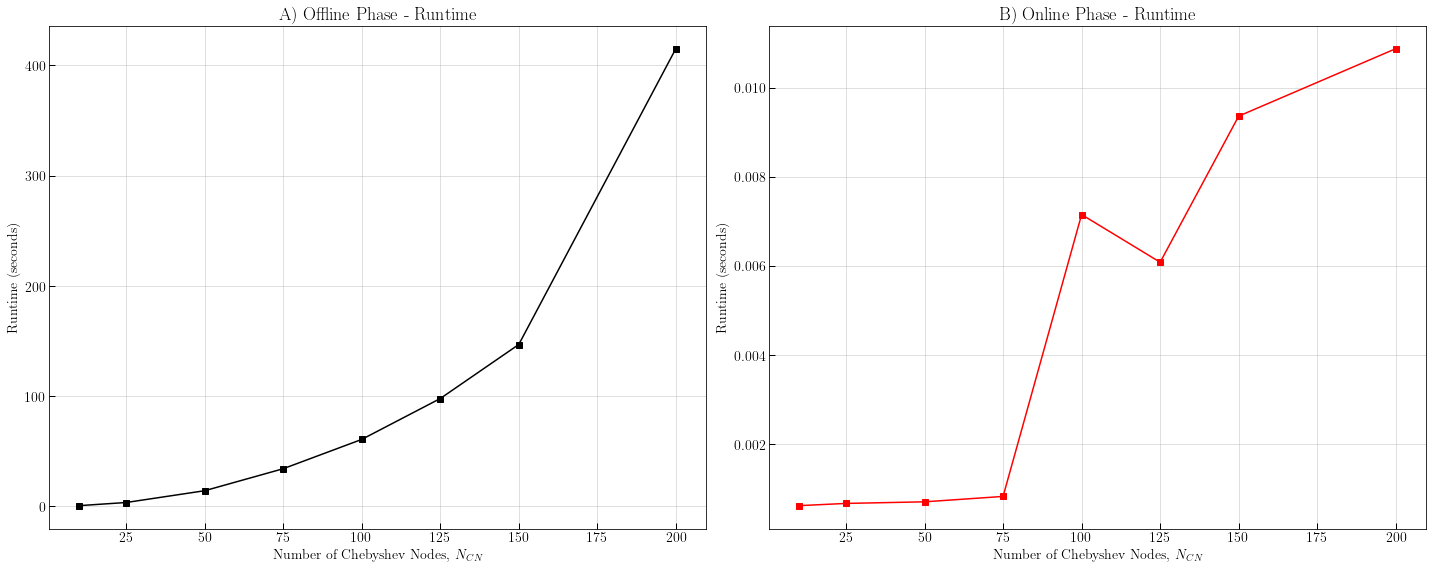

In [10]:
# The node counts and runtimes data (you should replace these with your actual data)
node_counts = [10, 25, 50, 75, 100, 125, 150, 200]

# Initialize figure with two subplots
plt.figure(figsize=(20, 8))

# First subplot for offline runtimes
plt.subplot(1, 2, 1)
plt.plot(node_counts, runtimes_offline, color='black', marker='s', label='Offline Phase Runtime')
plt.xlabel('Number of Chebyshev Nodes, $N_{CN}$', fontsize=14)
plt.ylabel('Runtime (seconds)', fontsize=14)
plt.title('A) Offline Phase - Runtime', size=18)
plt.tick_params(axis='both', direction='in', length=6, width=1, colors='black', grid_alpha=0.5, labelsize=14)
plt.grid(True)

# Second subplot for online runtimes
plt.subplot(1, 2, 2)
plt.plot(node_counts, runtimes_online, color='red', marker='s', label='Online Phase Runtime')
plt.xlabel('Number of Chebyshev Nodes, $N_{CN}$', fontsize=14)
plt.ylabel('Runtime (seconds)', fontsize=14)
plt.title('B) Online Phase - Runtime', size=18)
plt.tick_params(axis='both', direction='in', length=6, width=1, colors='black', grid_alpha=0.5, labelsize=14)
plt.grid(True)

plt.tight_layout()

# Check for directory and save the figure
output_directory = "../Results/plots"
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

plt.savefig(f"{output_directory}/RuntimeAnalysis.pdf", bbox_inches='tight')

# Display the plot
plt.show()